<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

import datetime
import IPython
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.103.232.170:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.103.232.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.232.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
hoje = datetime.date.today()
diaSemana = hoje.weekday()
hoje = str(hoje)

In [ ]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
historicoCarga

,Ano,Mes,Dia,Hora,Min,Carga
0,2014,1,1,1,0,31681.2
1,2014,1,1,2,0,31475.9
2,2014,1,1,3,0,30848.3
3,2014,1,1,4,0,29885.6
4,2014,1,1,5,0,29157.3
...,...,...,...,...,...,...
61987,2021,1,26,20,0,47868.2
61988,2021,1,26,21,0,48407.8
61989,2021,1,26,22,0,48234.6
61990,2021,1,26,23,0,46777.5


In [ ]:
def basePreprocessing(carga,temperatura):
    dataset = carga.merge(temperatura)
    dataset = dataset.drop(["Min"], axis = 1 )
    dataset = dataset.rename({'Ano': 'Year', 'Mes': 'Month',"Dia":"Day","Hora":"Hour"}, axis=1)
    dataset["Date"] = pd.to_datetime(dataset[["Year","Month","Day","Hour"]])
    dataset["Weekday"] = dataset["Date"].dt.dayofweek

    dataset["Carga_Var"] = dataset["Carga"].pct_change()
    dataset["Temp_Var"] = dataset["Temperatura"].pct_change()

    day = 24*60*60
    week = (7)*day
    year = (365.2425)*day
    
    timestamp_s = dataset["Date"].map(datetime.datetime.timestamp)
    
    dataset['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    dataset['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    dataset['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
    dataset['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

    dataset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    dataset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return dataset, timestamp_s

In [ ]:
historico, timestamp = basePreprocessing(historicoCarga,historicoTemperatura)
historico = historico.dropna()

cols = [  
    'Date',
    'Day sin',
    'Day cos',
    'Week sin',
    'Week cos',
    'Year sin',
    'Year cos',
    'Carga',
    'Temperatura',
    ]

historico = historico[cols]
base = historico.values
historico

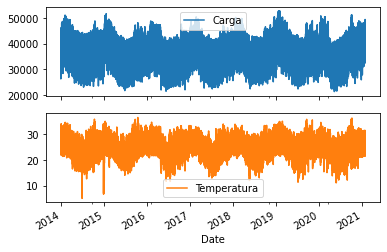

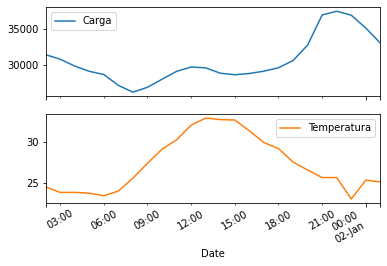

In [ ]:
plot_cols = ['Carga', 'Temperatura']
plot_features = historico[plot_cols]
plot_features.index = historico["Date"]
_ = plot_features.plot(subplots=True)

plot_features = historico[plot_cols][:24]
plot_features.index = historico["Date"][:24]
_ = plot_features.plot(subplots=True)

Text(0.5, 1.0, 'Time of day signal')

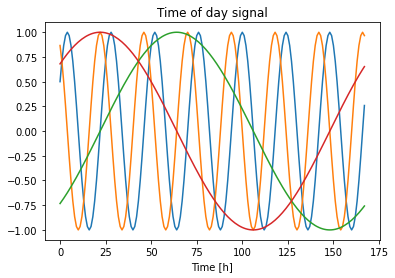

In [ ]:
plt.plot(np.array(historico['Day sin'])[:24*7])
plt.plot(np.array(historico['Day cos'])[:24*7])

plt.plot(np.array(historico['Week sin'])[:24*7])
plt.plot(np.array(historico['Week cos'])[:24*7])

plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0, 0.5, 'Temperatura [°C]')

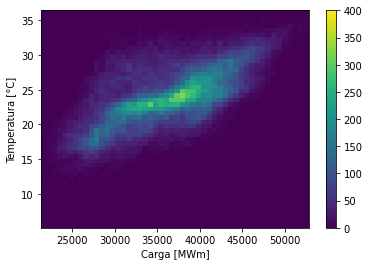

In [ ]:
plt.hist2d(historico['Carga'], historico['Temperatura'], bins=(50, 50), vmax=400)

plt.colorbar()
plt.xlabel('Carga [MWm]')
plt.ylabel('Temperatura [°C]')

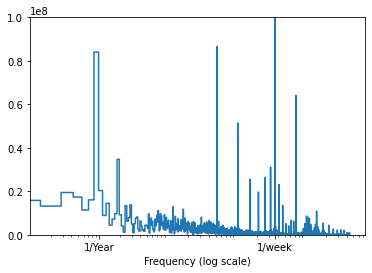

In [ ]:
fft = tf.signal.rfft(historico['Carga'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(historico['Carga'])

hours_per_year = 24*365.2524

years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))

plt.xscale('log')
plt.ylim(0, 10e7)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year','1/week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
Xdataset = historico[[
    'Day sin',
    'Day cos',
    'Week sin',
    'Week cos',
    'Year sin',
    'Year cos',
    'Carga',
    'Temperatura',]]

column_indices = {name: i for i, name in enumerate(Xdataset.columns)}

n = len(historico)

dias= 30

print(f'Tamanho original da base X = {Xdataset.shape}')

x_train = Xdataset[0:int(n*0.7)]

x_valid = Xdataset[int(n*0.7):int(n*0.9)]

x_test = Xdataset[int(n*0.9):]

num_features = historico.shape[1]

print(f'    formato dados de treino X = {x_train.shape}')
print(f'    formato dados de validação X = {x_valid.shape}')
print(f'    formato dados de teste X = {x_test.shape}')

Tamanho original da base X = (61984, 8)
    formato dados de treino X = (43388, 8)
    formato dados de validação X = (12397, 8)
    formato dados de teste X = (6199, 8)


In [ ]:
train_mean = x_train.mean()
train_std = x_train.std()

x_train = (x_train - train_mean) / train_std
x_valid = (x_valid - train_mean) / train_std
x_test = (x_test - train_mean) / train_std

In [ ]:
x_train

,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos,Carga,Temperatura
1,0.707024,1.224950,-1.036982,0.960091,0.007736,1.435038,-0.840788,0.126606
2,0.999896,1.000194,-1.000281,0.998171,0.008745,1.435030,-0.951739,-0.044900
3,1.224624,0.707286,-0.962182,1.034854,0.009754,1.435022,-1.121931,-0.044900
4,1.365894,0.366187,-0.922737,1.070087,0.010763,1.435013,-1.250685,-0.069875
5,1.414079,0.000143,-0.882001,1.103821,0.011772,1.435003,-1.330557,-0.148875
...,...,...,...,...,...,...,...,...
43390,-0.366029,1.366237,1.072138,0.920665,-0.429472,1.368056,1.494521,0.216819
43391,-0.000031,1.414428,1.105888,0.879949,-0.428510,1.368365,1.114236,0.083029
43392,0.365968,1.366237,1.138092,0.838001,-0.427548,1.368673,0.644109,-0.071149
43393,0.707024,1.224950,1.168704,0.794878,-0.426586,1.368980,0.226575,-0.071149


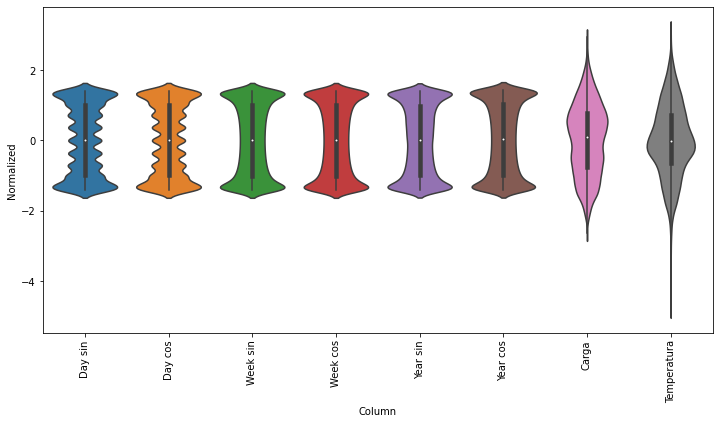

In [ ]:
df_std = (Xdataset - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(Xdataset.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = x_train, val_df=x_valid , test_df=x_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
standard_window = WindowGenerator(input_width=720, label_width=24, shift=24,
                     label_columns=['Carga'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(x_train[:standard_window.total_window_size]),
                           np.array(x_train[100:100+standard_window.total_window_size]),
                           np.array(x_train[200:200+standard_window.total_window_size])])


example_inputs, example_labels = standard_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 744, 8)
Inputs shape: (3, 720, 8)
labels shape: (3, 24, 1)


In [ ]:
standard_window.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Carga', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Carga')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
standard_window.train.element_spec

(TensorSpec(shape=(None, 720, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 720, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in standard_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 720, 8)
Labels shape (batch, time, features): (32, 720, 1)


In [ ]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience = 2):
  
    es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = patience, verbose = 1)
    rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = patience, verbose = 1)
    mcp = ModelCheckpoint(filepath=f"pesos-{datetime.date.today()}.h5", monitor = "loss", save_best_only = True, verbose=1)
  
    model.compile(
        optimizer = tf.optimizers.Adam(), 
        loss = tf.losses.MeanSquaredError(), 
        metrics = [tf.metrics.MeanAbsoluteError()])
  
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[es,rlr,mcp])
    return history

In [ ]:
lstm_model = Sequential([
    LSTM(units = 100, return_sequences = True),
    Dropout(0.5),
    LSTM(units = 32),
    Dense(units = 1)
])

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  lstm_model = Sequential([
    LSTM(units = 96, return_sequences = True),
    Dropout(0.5),
    LSTM(units = 32),
    Dropout(0.5),
    Dense(units = 1)
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 720, 32)           5248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 720, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('Input shape:', standard_window.example[0].shape)
print('Output shape:', lstm_model(standard_window.example[0]).shape)

Input shape: (32, 720, 8)
Output shape: (32, 1)


In [ ]:
history = compile_and_fit(model, standard_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(standard_window.val)
performance['LSTM'] = lstm_model.evaluate(standard_window.test, verbose=0)

from google.colab import files
files.download(f"pesos-{datetime.date.today()}.h5")

Epoch 1/200
1333/1333 [==============================] - 451s 336ms/step - loss: 0.6399 - mean_absolute_error: 0.6915 - val_loss: 0.6145 - val_mean_absolute_error: 0.6719

Epoch 00001: loss improved from inf to 0.63597, saving model to pesos-2021-03-14.h5
Epoch 2/200
1333/1333 [==============================] - 448s 336ms/step - loss: 0.6301 - mean_absolute_error: 0.6858 - val_loss: 0.6072 - val_mean_absolute_error: 0.6696

Epoch 00002: loss improved from 0.63597 to 0.62937, saving model to pesos-2021-03-14.h5
Epoch 3/200
1333/1333 [==============================] - 451s 339ms/step - loss: 0.6264 - mean_absolute_error: 0.6834 - val_loss: 0.6108 - val_mean_absolute_error: 0.6700

Epoch 00003: loss improved from 0.62937 to 0.62594, saving model to pesos-2021-03-14.h5
Epoch 4/200
1333/1333 [==============================] - 454s 340ms/step - loss: 0.6244 - mean_absolute_error: 0.6820 - val_loss: 0.6138 - val_mean_absolute_error: 0.6720

Epoch 00004: loss improved from 0.62594 to 0.62384, 

NameError: ignored

In [ ]:
performance['LSTM'] = model.evaluate(window.test, verbose=0)

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = model.metrics_names.index('mape')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 523.5589


In [ ]:
w2.plot(model)

# Teste e Validação


In [ ]:
model = keras.models.load_model('/content/pesos-2021-02-10.h5') # carrega modelo pré-treinado (OPCIONAL)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
testeDIR = "/content/drive/MyDrive/TG/TESTE" 

In [ ]:
historicoCargaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperaturaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
historicoTeste = basePreprocessing(historicoCargaTeste, historicoTemperaturaTeste)

historicoTeste, _ , _ = baseNormalizer(historicoTeste,
                                        StandardScaler(),
                                        normalize_fit=True)

valorRealTeste = historicoTeste.iloc[:, 4].values
valorRealTeste

In [ ]:
historicoTeste[["Carga"]] = normalizadorCarga.fit_transform(historicoTeste[["Carga"]])
historicoTeste[["Temperatura"]] = normalizadorTemp.fit_transform(historicoTeste[["Temperatura"]])
historicoTeste

In [ ]:
entradas = historicoTeste.values
entradas.shape

(62753, 13)

In [ ]:
X_teste = []
Y_teste = []
for i in range(len(entradas) - diasAnteriores,len(entradas)):
    cargaTeste = entradas[(i - diasAnteriores):i,4]
    cargaVerificada = entradas[i,4]
    tempTeste = entradas[(i+1 - diasAnteriores):i+1,5]
    vetorDiaSemana = entradas[(i+1 - diasAnteriores):i+1,6:]
    
    batchTeste = np.column_stack((cargaTeste,tempTeste,vetorDiaSemana))

    X_teste.append(batchTeste)
    Y_teste.append(cargaVerificada)
    
X_teste = np.array(X_teste)
Y_teste = np.array(Y_teste)
print(X_teste.shape)
print(Y_teste.shape)

In [ ]:
previsoes = model.predict(X_teste)

In [ ]:
previsoes = normalizadorCarga.inverse_transform(previsoes)
previsores

In [ ]:
loss = tf.keras.losses.mean_absolute_percentage_error(Y_teste, previsoes[:,0]).numpy()
loss

156.34515

In [ ]:
previsoes

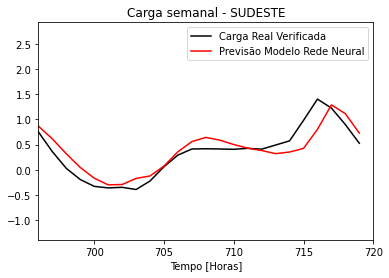

In [ ]:
axes = plt.gca()
axes.set_xlim(696,720)
plt.plot(Y_teste[:], color = "black", label = "Carga Real Verificada")
plt.plot(previsoes[:], color = "red", label = "Previsão Modelo Rede Neural")
plt.title("Carga semanal - SUDESTE")
plt.xlabel("Tempo [Horas]")
plt.ylabel("")
plt.legend()
plt.show()